In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pickle

In [2]:
def give_cl_cmb(ell, r=0, Alens=1.):
        
    power_spectrum = hp.read_cl('/home/oem/CMM-Pipeline/src/data/Cls_Planck2018_lensed_scalar.fits')[:,:4000]
    if Alens != 1.:
        power_spectrum[2] *= Alens
    if r:
        power_spectrum += r * hp.read_cl('/home/oem/CMM-Pipeline/src/data/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits')[:,:4000]
    return np.interp(ell, np.arange(1, 4001, 1), power_spectrum[2])

with open('/home/oem/CMM-Pipeline/src/autospectrum_foldertest_1_seed1.pkl', 'rb') as f:
    data = pickle.load(f)

# with open('spectrum_CMMnofg_50reals.pkl', 'rb') as f:
#     datanofg = pickle.load(f)

_f = data['ell'] * (data['ell'] + 1) / (2 * np.pi)

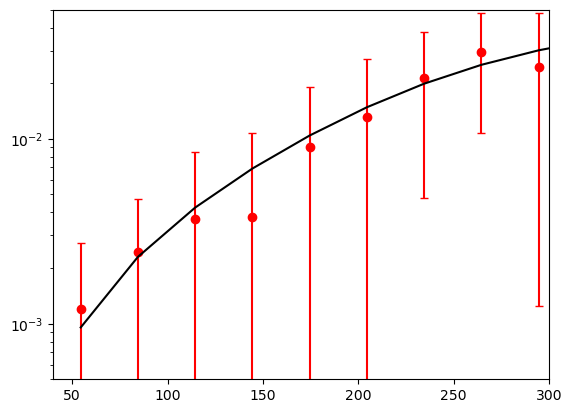

In [3]:
plt.figure()

plt.errorbar(data['ell'], np.mean(data['Dl'][:, 0], axis=0) - np.mean(data['Dl_1x1'], axis=0),
             yerr=np.std(data['Dl'][:, 0] - data['Dl_1x1'], axis=0), fmt='or', capsize=3)

# plt.errorbar(data['ell'], np.mean(datanofg['Dl'][:, 0], axis=0) - np.mean(datanofg['Dl_1x1'], axis=0),
#              yerr=np.std(datanofg['Dl'][:, 0] - datanofg['Dl_1x1'], axis=0), fmt='ob', capsize=3)

plt.errorbar(data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='-k')

plt.xlim(40, 300)
plt.yscale('log')
plt.ylim(5e-4, 5e-2)
plt.show()

In [17]:
print(data['Dl_1x1'].shape)
print(data['Dl'][:, 0].shape)

(50, 16)
(50, 16)


In [67]:
cov_cc = np.cov(data['Dl'][:, 0] - data['Dl_1x1'], data['Dl'][:, 0] - data['Dl_1x1'], rowvar=False)[:16, :16]
#cov_dd = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)[16:32, 16:32]
#cov_dc = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], data['Dl'][:, 0] - data['Dl_1x1'], rowvar=False)[16:32, :16]
#cov_cd = np.cov(data['Dl'][:, 0] - data['Dl_1x1'], data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)[:16, 16:32]

# cov_cc = np.cov(data['Dl'][:, 0] - (np.mean(data['Dl_1x1'],axis=0) + np.random.normal(loc=0,scale=np.std(data['Dl_1x1'],axis=0))), rowvar=False)
#cov_dd = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)
#cov_dc = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], data['Dl'][:, 0] - data['Dl_1x1'], rowvar=False)[16:32, :16]
#cov_cd = np.cov(data['Dl'][:, 0] - data['Dl_1x1'], data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)[:16, 16:32]

#cov_cc = np.cov(data['Dl'][:, 0], rowvar=False)
#cov_dd = np.cov(data['Dl'][:, 1], rowvar=False)
#cov_dc = np.cov(data['Dl'][:, 1], data['Dl'][:, 0], rowvar=False)[16:32, :16]
#cov_cd = np.cov(data['Dl'][:, 0], data['Dl'][:, 1], rowvar=False)[:16, 16:32]

In [68]:
# cov_cc = np.cov(data['Dl'][:, 0], rowvar=False)
#cov_dd = np.cov(data['Dl'][:, 1], rowvar=False)
#np.fill_diagonal(cov, np.std(data['Dl'], axis=0)[0]**2)

In [69]:
def foregrounds(ell, A, alpha):
    return A * (ell/80)**alpha
    
def log_prior(x):
    r, Alens = x
    if r > 1 or r < -1:
        return -np.inf

    if Alens < 0.1 or Alens > 1.9:
        return -np.inf

    #if A < 0:
    #    return -np.inf

    #if alpha > 0 or alpha < -1:
    #    return -np.inf
    return 0
def like(x):

    r, Alens = x

    ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens)])#, foregrounds(data['ell'], A, alpha)])
    #yobs = np.array([_f * give_cl_cmb(data['ell'], 0, 1)])#, foregrounds(data['ell'], 0.06, -0.1)])
    yobs = np.array([np.mean(data['Dl'], axis=0)[0] - np.mean(data['Dl_1x1'], axis=0)])#,
                     #np.mean(data['Dl'], axis=0)[1] - np.mean(data['Dl_2x2'], axis=0)])
    
    res = ymodel - yobs
    lp = log_prior(x)

    L_cmb_cmb = lp - 0.5 * ((res[0].T @ np.linalg.inv(cov_cc) @ res[0]))
    #L_dust_cmb = lp - 0.5 * (res[1].T @ np.linalg.inv(cov_dc) @ res[1])
    #L_cmb_dust = lp - 0.5 * (res[0].T @ np.linalg.inv(cov_cd) @ res[0])
    #L_dust_dust = lp - 0.5 * (res[1].T @ np.linalg.inv(cov_dd) @ res[1])

    L = L_cmb_cmb# + L_dust_dust + L_dust_cmb + L_cmb_dust
    
    return L

In [70]:
import emcee
from multiprocess import Pool
from getdist import plots, MCSamples

nwalkers = 30

In [71]:
x0 = np.zeros((nwalkers, 2))

x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
#x0[:, 2] = np.random.normal(-0.1, 0.001, (nwalkers))
#x0[:, 3] = np.random.normal(-0.1, 0.001, (nwalkers))
#x0[:, 2] = np.random.normal(-0.5, 0.001, (nwalkers))
print(x0.shape)

(30, 2)


In [72]:
from multiprocess import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, x0.shape[1], like, pool=pool)
    sampler.run_mcmc(x0, 500, progress=True)

100%|█████████████████████████████████████████| 500/500 [03:08<00:00,  2.66it/s]


In [73]:
chainflat = sampler.get_chain(discard=300, thin=15, flat=True)
chains = sampler.get_chain()

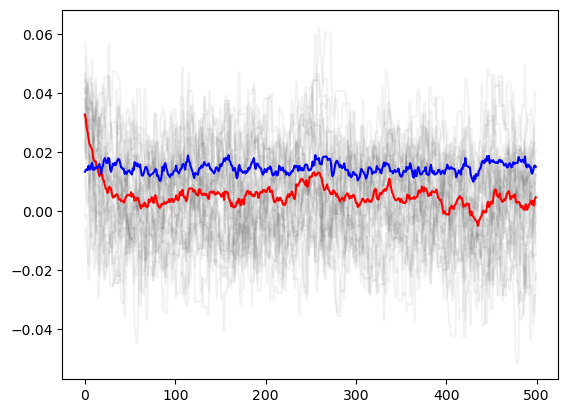

In [74]:
for i in range(nwalkers):
    plt.plot(chains[:, i, 0], '-k', alpha=0.05)
plt.plot(np.mean(chains, axis=1)[:, 0], '-r')
plt.plot(np.std(chains, axis=1)[:, 0], '-b')
# plt.axhline(0, ls='--', color='black')
# plt.axhline(0.015, ls='--', color='green')
# plt.xlim(0, chains.shape[0])
# plt.ylim(-0.05, 0.1)

Removed no burn in


<Figure size 1200x800 with 0 Axes>

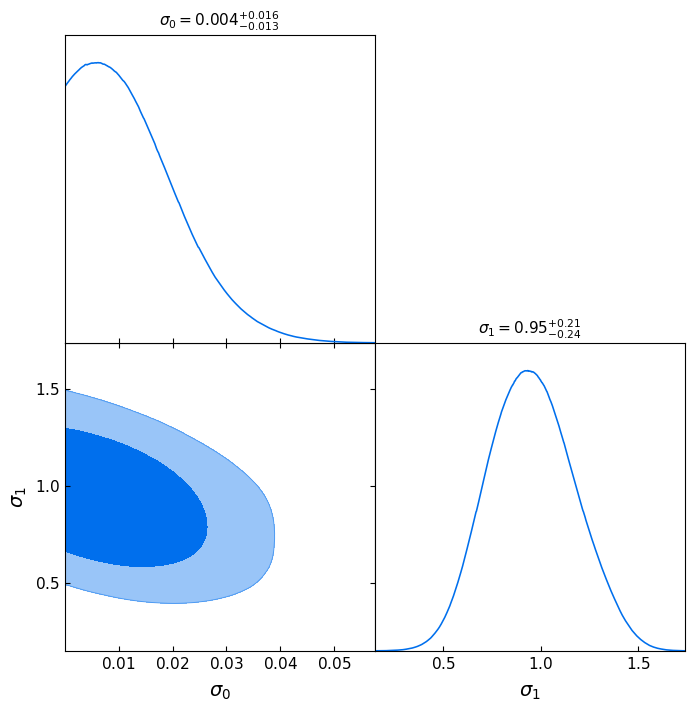

In [75]:
labels = []
names = []

for i in range(chains.shape[2]):
    names += [f'sig_{i}']
    labels += [f'\sigma_{i}']
            
s = MCSamples(samples=chainflat, names=names, labels=labels, label=r'', ranges={'sig_0':(0, None)})

plt.figure(figsize=(12, 8))

# Triangle plot
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([s], filled=True, title_limit=1)

plt.show()

# Results ($A_{lens}$ free)

## NO FG
  - CMB cov corrected     :  0.0000 +- 0.0100
  - CMB cov not corrected :  0.0000 +- 0.0430
 
## FG 
  - CMB cov corrected     : -0.0023 +- 0.0100
  - CMB cov not corrected : -0.0010 +- 0.0430

In [13]:
print(np.mean(chainflat, axis=0))
print(np.std(chainflat, axis=0))

[0.0019969  0.96150059]
[0.015696   0.21090479]


In [15]:
# plt.figure()

# plt.errorbar(data['ell'], np.mean(datanofg['Dl'][:, 0], axis=0) - np.mean(datanofg['Dl_1x1'], axis=0),
#              yerr=np.std(datanofg['Dl'][:, 0] - datanofg['Dl_1x1'], axis=0), fmt='or', capsize=3)

# #plt.errorbar(data['ell'], np.mean(datanofg['Dl'][:, 0], axis=0) - np.mean(datanofg['Dl_1x1'], axis=0),
# #             yerr=np.std(datanofg['Dl'][:, 0] - datanofg['Dl_1x1'], axis=0), fmt='ob', capsize=3)

# plt.errorbar(data['ell'], _f * give_cl_cmb(datanofg['ell'], 0, 1), fmt='-k')
# #plt.errorbar(data['ell'], _f * give_cl_cmb(data['ell'], *np.mean(chainflat, axis=0)), fmt='-g')
# plt.errorbar(data['ell'], _f * give_cl_cmb(datanofg['ell'], 0.01, 1), fmt='-m')

# plt.xlim(40, 250)
# plt.yscale('log')
# plt.ylim(5e-4, 5e-2)
# plt.show()